# Определение перспективного тарифа для телеком компании.

В нашем распоряжении два тарифных плана «Мегалайн» — федерального оператора сотовой связи, которые предлагают клиентам: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Откроем файлы с данными и изучим общую информацию.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

#### Таблица calls (информация о звонках).

In [2]:
df_calls = pd.read_csv('/datasets/calls.csv', index_col=0)
df_calls.info()
df_calls.head()

<class 'pandas.core.frame.DataFrame'>
Index: 202607 entries, 1000_0 to 1499_219
Data columns (total 3 columns):
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.2+ MB


,call_date,duration,user_id
id,,,
1000_0,2018-07-25,0.00,1000
1000_1,2018-08-17,0.00,1000
1000_2,2018-06-11,2.85,1000
1000_3,2018-09-21,13.80,1000
1000_4,2018-12-15,5.18,1000


    id — уникальный номер звонка
    call_date — дата звонка
    duration — длительность звонка в минутах
    user_id — идентификатор пользователя, сделавшего звонок

#### Таблица internet (информация об интернет-сессиях).

In [3]:
df_internet = pd.read_csv('/datasets/internet.csv', index_col=0)
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя

#### Таблица messages (информация о сообщениях).

In [4]:
df_messages = pd.read_csv('/datasets/messages.csv', index_col=0)
df_messages.info()
df_messages.head()

<class 'pandas.core.frame.DataFrame'>
Index: 123036 entries, 1000_0 to 1499_183
Data columns (total 2 columns):
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.8+ MB


,message_date,user_id
id,,
1000_0,2018-06-27,1000
1000_1,2018-10-08,1000
1000_2,2018-08-04,1000
1000_3,2018-06-16,1000
1000_4,2018-12-05,1000


    id — уникальный номер сообщения
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение

#### Таблица tariffs (информация о тарифах).

In [5]:
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_tariffs.info()
df_tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra



    tariff_name — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100     минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


#### Таблица users (информация о пользователях).

In [6]:
df_users = pd.read_csv('/datasets/users.csv')
df_users.info()
df_users.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
499,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart


    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tariff — название тарифного плана

### Подготовка данных .

#### Приводим данные времени к date_time. 

In [7]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')

#### Округлим продолжительность звонков до целых минут и мегабайтов трафика в большую сторону

In [8]:
df_calls['duration'] = df_calls['duration'].apply(np.ceil)

df_internet['mb_used'] = df_internet['mb_used'].apply(np.ceil)

In [9]:
df_calls.loc[df_calls['duration'] == 0, 'duration'].value_counts()[0]

39613

Есть звонки, продолжительность которых равна 0. Оставим их в таком виде и не будем преобразовывать, так как такие звонки могут означать то, что пользователь просто не дозвонился, а значит не минуты, не рубли за это не взымаются. 

In [10]:
df_calls['duration'].count

<bound method Series.count of id
1000_0       0.0
1000_1       0.0
1000_2       3.0
1000_3      14.0
1000_4       6.0
            ... 
1499_215     1.0
1499_216    19.0
1499_217    11.0
1499_218     5.0
1499_219    20.0
Name: duration, Length: 202607, dtype: float64>

In [11]:
df_internet.loc[df_internet['mb_used'] == 0, 'mb_used'].value_counts()[0]

19598

В таблице зафиксированы интернет-сессии с 0 мб интернет-трафика. Удалять мы такие данные не будем, чтобы не лишиться часть информации и иметь. Такие данные могут означать что угодно. Например сработало огрничение при привышении лимита интернет-трафика, пользователю прислали сообщение в мессенджере, или пришло уведомление.

#### Количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя.



In [12]:
df_calls['month'] = df_calls['call_date'].dt.month

In [13]:
calls = df_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum']).reset_index()
calls.columns = ['user_id', 'month', 'calls_count', 'calls_sum']
calls

,user_id,month,calls_count,calls_sum
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0
...,...,...,...,...
3169,1498,10,41,247.0
3170,1499,9,9,70.0
3171,1499,10,68,449.0
3172,1499,11,74,612.0


#### Количество отправленных сообщений по месяцам для кадого пользователя. 

In [14]:
df_messages['month'] = df_messages['message_date'].dt.month


In [15]:
messages = df_messages.pivot_table(index=['user_id', 'month'], values=['message_date'], aggfunc='count').reset_index()
messages.columns = ['user_id', 'month', 'messages_count']
messages

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


#### Объем израсходованного интернет-трафика по месяцам для каждого пользователя

In [16]:
df_internet['month'] = df_internet['session_date'].dt.month

In [17]:
internet = df_internet.pivot_table(index=['user_id', 'month'], values=['mb_used'], aggfunc='sum').reset_index()
internet.columns = ['user_id', 'month', 'mb_sum_internet']
internet

,user_id,month,mb_sum_internet
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0
3,1000,8,14070.0
4,1000,9,14581.0
...,...,...,...
3198,1498,10,20604.0
3199,1499,9,1848.0
3200,1499,10,17809.0
3201,1499,11,17984.0


#### Общая таблица звонков, сообщений и интернет-трафика каждого пользователя по месяцам. 

In [18]:
total = calls \
    .merge(messages, how='outer', on=['user_id', 'month']) \
    .merge(internet, how='outer', on=['user_id', 'month']) \
    .merge(df_users[['user_id', 'tariff', 'city']], on='user_id', how='right')

total.head(15)

,user_id,month,calls_count,calls_sum,messages_count,mb_sum_internet,tariff,city
0,1000,5.0,22.0,159.0,22.0,2256.0,ultra,Краснодар
1,1000,6.0,43.0,172.0,60.0,23257.0,ultra,Краснодар
2,1000,7.0,47.0,340.0,75.0,14016.0,ultra,Краснодар
3,1000,8.0,52.0,408.0,81.0,14070.0,ultra,Краснодар
4,1000,9.0,58.0,466.0,57.0,14581.0,ultra,Краснодар
5,1000,10.0,57.0,350.0,73.0,14717.0,ultra,Краснодар
6,1000,11.0,43.0,338.0,58.0,14768.0,ultra,Краснодар
7,1000,12.0,46.0,333.0,70.0,9827.0,ultra,Краснодар
8,1001,11.0,59.0,430.0,NaN,18452.0,smart,Москва
9,1001,12.0,63.0,414.0,NaN,14053.0,smart,Москва


#### Расчет помесячной выручки с каждого пользователя.

Пропущенные значения заменяем на нули.

In [19]:
total.loc[total['calls_sum'].isna(), 'calls_sum'] = 0
total.loc[total['messages_count'].isna(), 'messages_count'] = 0
total.loc[total['mb_sum_internet'].isna(), 'mb_sum_internet'] = 0

Пропишем функцию расчета месяного дохода.

In [20]:
def monthly_revenue(row):

    messages_count = row['messages_count']
    mb_sum_internet = row['mb_sum_internet']
    tariff = row['tariff']
    calls_sum = row['calls_sum']
    calls_count = row['calls_count']
    
    if tariff == 'smart':
        extra_duration = calls_sum - df_tariffs.loc[0, 'minutes_included']
        extra_mb = mb_sum_internet - df_tariffs.loc[0, 'mb_per_month_included']
        extra_messages = messages_count - df_tariffs.loc[0, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (df_tariffs.loc[0, 'rub_per_message'] * extra_messages + 
                   (df_tariffs.loc[0, 'rub_per_gb'] / 1024) * extra_mb + 
                   df_tariffs.loc[0, 'rub_per_minute'] * extra_duration + 
                   df_tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        extra_duration = calls_sum - df_tariffs.loc[1, 'minutes_included']
        extra_mb = mb_sum_internet - df_tariffs.loc[1, 'mb_per_month_included']
        extra_messages = messages_count - df_tariffs.loc[1, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (df_tariffs.loc[1, 'rub_per_message'] * extra_messages + 
                   (df_tariffs.loc[1, 'rub_per_gb'] / 1024) * extra_mb + 
                   df_tariffs.loc[1, 'rub_per_minute'] * extra_duration + 
                   df_tariffs.loc[1, 'rub_monthly_fee']
                  )

total['monthly_revenue'] = total.apply(monthly_revenue, axis=1)
total.head(10)

,user_id,month,calls_count,calls_sum,messages_count,mb_sum_internet,tariff,city,monthly_revenue
0,1000,5.0,22.0,159.0,22.0,2256.0,ultra,Краснодар,1950.00000
1,1000,6.0,43.0,172.0,60.0,23257.0,ultra,Краснодар,1950.00000
2,1000,7.0,47.0,340.0,75.0,14016.0,ultra,Краснодар,1950.00000
3,1000,8.0,52.0,408.0,81.0,14070.0,ultra,Краснодар,1950.00000
4,1000,9.0,58.0,466.0,57.0,14581.0,ultra,Краснодар,1950.00000
5,1000,10.0,57.0,350.0,73.0,14717.0,ultra,Краснодар,1950.00000
6,1000,11.0,43.0,338.0,58.0,14768.0,ultra,Краснодар,1950.00000
7,1000,12.0,46.0,333.0,70.0,9827.0,ultra,Краснодар,1950.00000
8,1001,11.0,59.0,430.0,0.0,18452.0,smart,Москва,1153.90625
9,1001,12.0,63.0,414.0,0.0,14053.0,smart,Москва,550.00000


### Анализ данныз использования  тарифа пользователем. 

#### Посчитаем сколько в среднем минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 

In [21]:
medians = total.pivot_table(index=['user_id', 'tariff'], values=['calls_sum', 'messages_count', 'mb_sum_internet', 'monthly_revenue'], aggfunc='sum')
medians.head(10)

,,calls_sum,mb_sum_internet,messages_count,monthly_revenue
user_id,tariff,,,,
1000,ultra,2566.0,107492.0,496.0,15600.000000
1001,smart,844.0,32505.0,0.0,1703.906250
1002,smart,1517.0,116183.0,70.0,6702.929688
1003,ultra,3822.0,57329.0,380.0,9750.000000
1004,ultra,987.0,149172.0,1192.0,15600.000000
1005,smart,6605.0,99813.0,552.0,9924.000000
1006,smart,3501.0,164395.0,0.0,9612.304688
1007,smart,4379.0,131792.0,225.0,7790.726562
1008,smart,339.0,13236.0,56.0,568.000000


#### Посчитаем среднее количество, дисперсию и стандартное отклонение.

In [22]:
descriptive_statistics = total.pivot_table(index=['tariff'], values=['calls_sum', 'mb_sum_internet', 'messages_count'], 
                    aggfunc={'calls_sum': [np.median, np.var, np.std], 
                             'mb_sum_internet': [np.median, np.var, np.std], 
                             'messages_count': [np.median, np.var, np.std]})
descriptive_statistics

calls_sum                            mb_sum_internet                \
          median         std            var          median           std   
tariff                                                                      
smart      421.5  190.476754   36281.393836         16529.0   5886.299627   
ultra      518.0  317.887549  101052.493549         19320.0  10110.255401   

                     messages_count                          
                 var         median        std          var  
tariff                                                       
smart   3.464852e+07           28.0  28.230396   796.955256  
ultra   1.022173e+08           38.0  47.806040  2285.417425

Посторим графики

Text(3.674999999999997, 0.5, 'Кол-во сообщений')

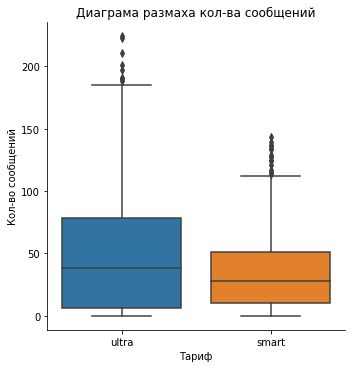

In [23]:
sns.catplot(x='tariff',
            y='messages_count',
            kind='box',
            data=total)
plt.title('Диаграма размаха кол-ва сообщений')
plt.xlabel('Тариф')
plt.ylabel('Кол-во сообщений')

Text(-8.700000000000003, 0.5, 'Кол-во интернет-трафика')

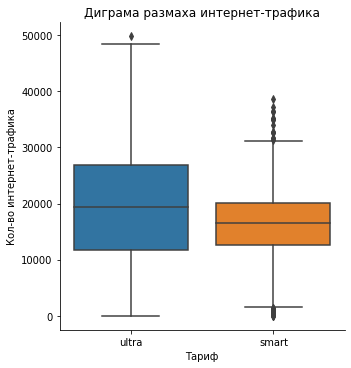

In [24]:
sns.catplot(x='tariff',
            y='mb_sum_internet',
            kind='box',
            data=total)
plt.title('Диграма размаха интернет-трафика')
plt.xlabel('Тариф')
plt.ylabel('Кол-во интернет-трафика')

Text(-2.700000000000003, 0.5, 'Продолжительность звоков')

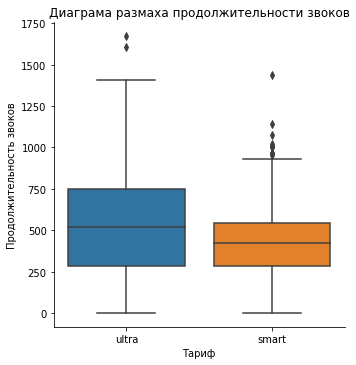

In [25]:
sns.catplot(x='tariff',
            y='calls_sum',
            kind='box',
            data=total)
plt.title('Диаграма размаха продолжительности звоков')
plt.xlabel('Тариф')
plt.ylabel('Продолжительность звоков')

Минуты разговора, число сообщений и объем потраченного интернет-трафика по тарифу «Ультра» имеет большую дисперсию по сравнению с тарифом «Смарт», и медианы по вышеперечисленным признакам также смещены в большую сторону. Кроме того, выбросов в рамках более дешевого тарифа существенно больше.

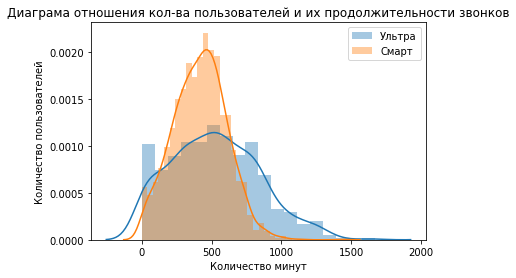

In [26]:
for tariff in ['ultra', 'smart']:
    sns.distplot(total.query('tariff == @tariff')['calls_sum'], label=tariff)
    plt.legend(['Ультра', 'Смарт'])
    plt.xlabel('Количество минут')
    plt.ylabel('Количество пользователей')
    plt.title('Диаграма отношения кол-ва пользователей и их продолжительности звонков')

Пользователи тарифа "Ультра" тратять на звонки примерно 200-700 мин в месяц, а пользователи тарифа "Смарт" тратять на звонки примерно до 900 мин в месяц.

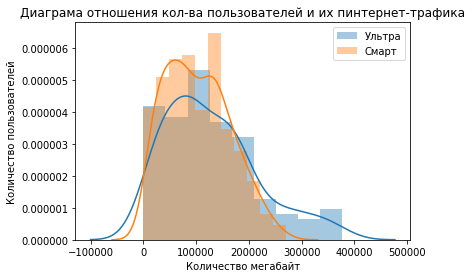

In [27]:
for tariff in ['ultra', 'smart']:
    sns.distplot(medians.query('tariff == @tariff')['mb_sum_internet'])
    plt.legend(['Ультра', 'Смарт'])
    plt.xlabel('Количество мегабайт')
    plt.ylabel('Количество пользователей')
    plt.title('Диаграма отношения кол-ва пользователей и их пинтернет-трафика')

У пользователей обоих тарифов схожее количество интернет-трафика.

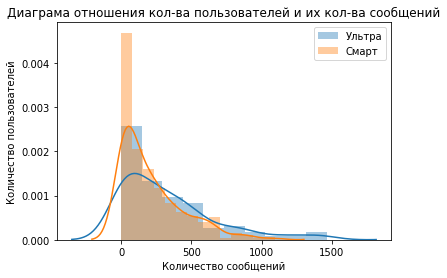

In [28]:
for tariff in ['ultra', 'smart']:
    sns.distplot(medians.query('tariff == @tariff')['messages_count'], label=tariff)
    plt.legend(['Ультра', 'Смарт'])
    plt.xlabel('Количество сообщений')
    plt.ylabel('Количество пользователей')
    plt.title('Диаграма отношения кол-ва пользователей и их кол-ва сообщений')

Пользователи обоих тарифов практически не используют сообщения. 

### Проверка гипотез. 

#### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

H0: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается.

H1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

In [29]:
ultra = total.query('tariff == "ultra"')['monthly_revenue']
smart = total.query('tariff == "smart"')['monthly_revenue']

alpha = .01

results = st.ttest_ind(
    ultra, 
    smart, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.665639404941842e-296
Отвергаем нулевую гипотезу


#### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [30]:
moscow = total.query('city == "Москва"')['monthly_revenue']
region = total.query('city != "Москва"')['monthly_revenue']

alpha = .01

results = st.ttest_ind(
    moscow, 
    region, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4517561756356935
Не получилось отвергнуть нулевую гипотезу


### Общий вывод. 

В результате статистического анализа выборки из 500 пользователей Мегалайн мы пишли к выводу, что доход от тарифа «Ультра» больше, чем от тарифа «Смарт».  
Мы подтвердили две наши гипотезы в п. 4.1 и 4.2. 
Так же проанализировав данные, мы пришли к выводу, что пользователи обоих тарифов практически не используют сообщения, а количество интернет-трафика схожее. Но при этом пользователи тарифа «Ультра» не выходят за рамки тарифа, а пользователи тарифа «Смарт» практически вдвое привышают лимит, а выручка от жителей Москвы не отличается от отсальных регионов. 